Kraaijenbrink et al. (2017) compiled data on the impact of debris cover on glacier melt (Fig. S5).

<img src="./images/nature23878-s1_debris_impact.PNG" style="width: 500px;"/>
Full Reference:
Kraaijenbrink, P. D. A., Bierkens, M. F. P., Lutz, A. F., & Immerzeel, W. W. (2017). Impact of a global temperature rise of 1.5 degrees Celsius on Asia’s glaciers. Nature, 549(7671), 257–260. https://doi.org/10.1038/nature23878

The black line is the average of their findings. The purpose of this workbook is to identify an analytical function that approximates the black line.

The first step in this process is using the data scraper https://apps.automeris.io/wpd/
The output is a CSV file of data points along the black line.

In [1]:
import numpy as np

from numpy import genfromtxt
debris_data = genfromtxt('./data/debris_cover_melt_impact_Kraaijenbrink.csv', delimiter=',')

In [2]:
x = debris_data[:,1]
y_obs = debris_data[:,0]

Plot data:

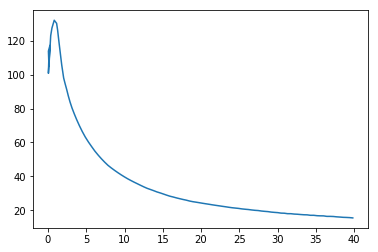

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y_obs)

Check the maximum point (used in some of the function defs)

In [4]:
indymax = np.argmax(y_obs)
print(x[indymax], y_obs[indymax])

0.82 132.09


# Implement three functions that can be optimized to fit the data

## Define piecewise linear function that can be optimized to fit data:

In [5]:
def pwlin(x, a1, a2, a3, m1, m2, m3, m4):
    a0 = 0
    
    b1 = 100
    b2 = b1 + m1*(a1-a0)
    b3 = b2 + m2*(a2-a1)
    b4 = b3 + m3*(a3-a2)
    conds = [              
             (x >= a0) & (x < a1), 
             (x >= a1) & (x < a2), 
             (x >= a2) & (x < a3),
              x >= a3         
            ]
    funcs = [
             lambda x: b1 + m1*(x - a0), 
             lambda x: b2 + m2*(x - a1), 
             lambda x: b3 + m3*(x - a2),
             lambda x: b4 + m4*(x - a3)
            ]
    return np.piecewise(x, conds, funcs)

In [6]:
from scipy.optimize import curve_fit

poptlin, pcovlin = curve_fit(pwlin, x, y_obs, p0 = [1.1,4,15,37,-18,-4,-0.8])

<function matplotlib.pyplot.show>

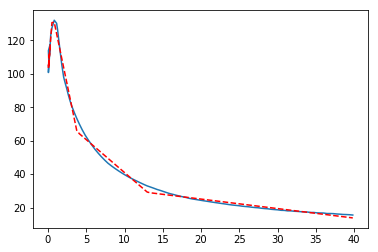

In [7]:
plt.plot(x, y_obs)
plt.plot(x, pwlin(x,poptlin[0],poptlin[1],poptlin[2],poptlin[3],poptlin[4],poptlin[5],poptlin[6]), 'r--')
plt.show

## Define quadratic function to fit the data

In [8]:
def pw1x(x, m2, c2, b2):
    y0 = 100
    y1 = 132.09
    a0 = 0
    a1 = 0.82
    
    m1 = (y1-y0)/(a1-a0)
    
    #m2 = max(m2,0.0001)
    c2 = max(c2,-a1+0.001)
    
    conds = [              
             (x >= a0) & (x <= a1), 
              x > a1     
            ]
    funcs = [
             lambda x: y0 + m1*x, 
             lambda x: y1 + m2/(x + c2)**2 + b2, 
            ]
    return np.piecewise(x, conds, funcs)

<function matplotlib.pyplot.show>

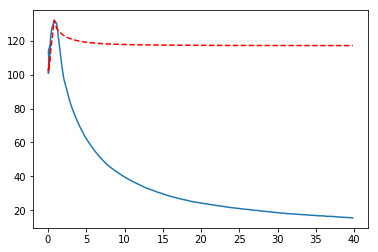

In [9]:
plt.plot(x, y_obs)
plt.plot(x, pw1x(x, 100,2,-15), 'r--')
plt.show

In [10]:
popt1x, pcov1x = curve_fit(pw1x, x, y_obs, p0 = [100,2,15])

<function matplotlib.pyplot.show>

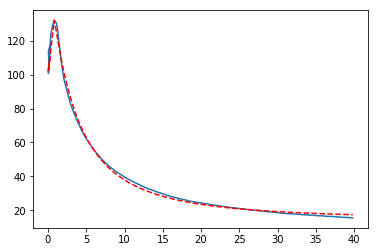

In [11]:
plt.plot(x, y_obs)
plt.plot(x, pw1x(x,popt1x[0],popt1x[1],popt1x[2]), 'r--')
plt.show

## Define natural log function to fit the data

In [12]:
def pwln(x, m2, m3, c2):
    y0 = 100
    y1 = 132.09
    a0 = 0
    a1 = 0.82
    
    m1 = (y1-y0)/(a1-a0)
    
    b2 = y1
    
    conds = [              
             (x >= a0) & (x <= a1), 
              x > a1     
            ]
    funcs = [
             lambda x: y0 + m1*x, 
             lambda x: b2 + m2*np.log(m3*x - c2), 
            ]
    return np.piecewise(x, conds, funcs)

<function matplotlib.pyplot.show>

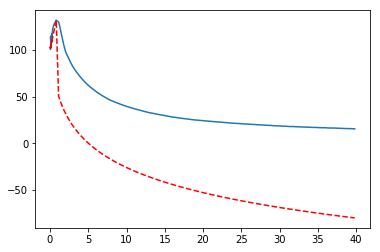

In [13]:
plt.plot(x, y_obs)
plt.plot(x, pwln(x, -40,5,-2), 'r--')
plt.show

In [14]:
poptln, pcovln = curve_fit(pwln, x, y_obs, p0 = [-40,1,-2])

## Visually test all three functions

<function matplotlib.pyplot.show>

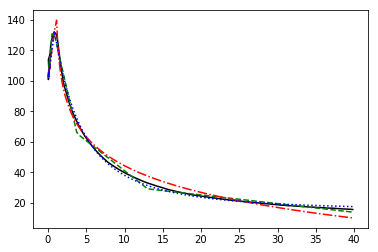

In [15]:
plt.plot(x, y_obs, 'black')
plt.plot(x, pwlin(x,poptlin[0],poptlin[1],poptlin[2],poptlin[3],poptlin[4],poptlin[5],poptlin[6]), 'g--')
plt.plot(x, pwln(x, poptln[0], poptln[1], poptln[2]), 'r-.')
plt.plot(x, pw1x(x, popt1x[0], popt1x[1], popt1x[2]), 'b:')
plt.show

The quadratic function appears to perform best, which can be confirmed quantitatively:

In [16]:
maelin = np.mean(abs(y_obs - pwlin(x,poptlin[0],poptlin[1],poptlin[2],poptlin[3],poptlin[4],poptlin[5],poptlin[6])))
maeln = np.mean(abs(y_obs - pwln(x, poptln[0], poptln[1], poptln[2])))
mae1x = np.mean(abs(y_obs - pw1x(x, popt1x[0], popt1x[1], popt1x[2])))

print('MAE for piecewise quadratic function: ', np.around(mae1x,2))
print('MAE for piecewise linear function: ', np.around(maelin,2))
print('MAE for piecewise natural log function: ', np.around(maeln,2))

MAE for piecewise quadratic function:  1.61
MAE for piecewise linear function:  1.75
MAE for piecewise natural log function:  3.3


The optimized parameters for the quadratic function are:

In [17]:
popt1x

array([ 6375.15046863,     6.46889438,  -117.65100993])